## Homework 2 logbook
Started with a vanilla unet without skip connections, sadly IoU was going backwards.
Adapted laboratory model using vgg as backbone and got a straight 30 IoU,
added some skip cons but still it got worsened, finally I implemented a rough patching function to better parallelize computations and implemented a U-net with 2 skip connections having ResNet as backbone, with that I reached
about 60 IoU with validation, for the submission I patch the test set as well and repatch it after prediction, the rest of the notebook is self explanatory. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

In [3]:
cwd = os.getcwd()

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
if not os.path.exists('Development_Dataset'):
  !unzip /content/drive/My\ Drive/Development_Dataset.zip

Archive:  /content/drive/My Drive/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Developm

In [6]:
!unzip /content/drive/My\ Drive/Final_Dataset.zip

Archive:  /content/drive/My Drive/Final_Dataset.zip
   creating: Test_Dev/
   creating: Test_Dev/Bipbip/
   creating: Test_Dev/Bipbip/Haricot/
   creating: Test_Dev/Bipbip/Haricot/Images/
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02901.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_03691.jpg  
  inflating: Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_06581.jpg 

In [7]:
# Before merging
!ls Development_Dataset/Training/Bipbip/Haricot/Images/ | wc -l

90


In [8]:
!rm -R Development_Dataset/Test_Dev/
!rsync -a Test_Dev/ Development_Dataset/Training/
!rsync -a Test_Final/ Development_Dataset/Test_Dev/
!rm -R Test_Dev/
!rm -R Test_Final/

In [9]:
# After merging
!ls Development_Dataset/Training/Bipbip/Haricot/Images/ | wc -l

105


In [10]:
!ls Development_Dataset/Test_Dev/Bipbip/Haricot/Images/ | wc -l

20


# Image Segmentation
## Build segmentation

In [11]:
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
crops = ['Haricot', 'Mais']

window = 256

In [12]:
import math

def patching(img, window):
  height, width, _ = img.shape

  cols = math.ceil(width/window)
  rows = math.ceil(height/window)
  patches = []

  for row in range(rows):
      start_row = row * window
      end_row = start_row + window
      # Last patch window
      if end_row > height:
        start_row = height - window
        end_row = height
      for col in range(cols):
          start_col = col * window
          end_col = start_col + window
          # Last patch window
          if end_col > width:
            start_col = width - window
            end_col = width
          patch = img[start_row:end_row,start_col:end_col,:]
          patches.append(patch)

  return patches

In [13]:
from PIL import Image

dataset_src = os.path.join(cwd, 'Development_Dataset', 'Training')
dataset_dst = os.path.join(cwd, 'Patches')

for team in teams:
  for crop in crops:

    is_patched = True
    dst_dir = os.path.join(dataset_dst, team+crop)
    
    if not os.path.exists(os.path.join(dst_dir, 'Images')):
        os.makedirs(os.path.join(dst_dir, 'Images'))
        is_patched = False

    if not os.path.exists(os.path.join(dst_dir, 'Masks')):
        os.makedirs(os.path.join(dst_dir, 'Masks'))
        is_patched = False

    if is_patched == False:
      dataset_dir = os.path.join(dataset_src, team, crop)
      img_path = os.path.join(dataset_dir, 'Images')
      fnames = os.listdir(img_path)

      # Removing extensions
      fnames = [os.path.splitext(fname)[0] for fname in fnames]

      for fname in fnames:
        print("Patching... {}".format(fname))
        # Read Image
        if 'Roseau' in fname:
          img_path = os.path.join(dataset_dir, 'Images', fname + '.png')
        else:
          img_path = os.path.join(dataset_dir, 'Images', fname + '.jpg')
        msk_path = os.path.join(dataset_dir, 'Masks', fname + '.png')

        img = Image.open(img_path)
        img_arr = np.array(img)

        msk = Image.open(msk_path)
        msk_arr = np.array(msk)

        # pix to class
        msk_arr = msk_arr[...,-1]
        msk_arr[msk_arr == 18] = 0
        msk_arr[msk_arr == 255] = 1
        msk_arr[msk_arr == 82] = 2
        msk_arr = np.expand_dims(msk_arr, -1)

        img_patches = patching(img_arr, window)
        msk_patches = patching(msk_arr, window)

        for i in range(len(img_patches)):
          pname = '{}_patch{}'.format(fname,i)
          print("\tPatch {} - {}".format(pname, np.unique(msk_patches[i])))

          img_path = os.path.join(dst_dir, 'Images', pname)
          np.save(img_path, img_patches[i])

          msk_path = os.path.join(dst_dir, 'Masks', pname)
          np.save(msk_path, msk_patches[i])

Output streaming troncato alle ultime 5000 righe.
	Patch Weedelec_mais_2019-09-25T121559-243_patch14 - [0 1]
	Patch Weedelec_mais_2019-09-25T121559-243_patch15 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch16 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch17 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch18 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch19 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch20 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch21 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch22 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch23 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch24 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch25 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch26 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch27 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch28 - [0]
	Patch Weedelec_mais_2019-09-25T121559-243_patch29 - [0]
	Patch Weedelec_mais_2019-09-25T1215

In [14]:
# Colab does not have enough space
!rm -R /content/Development_Dataset/Training

In [15]:
# ImageDataGenerator
# ------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=5,
                    width_shift_range=5,
                    height_shift_range=5,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='constant',
                    cval=0)

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(**data_gen_args)  
    mask_data_gen = ImageDataGenerator(**data_gen_args)
else:
    img_data_gen = None
    mask_data_gen = None

In [16]:
from PIL import Image
import random

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
  """
  def __init__(self, dataset_dirs, which_subset, validation_split=0,
               img_generator=None, mask_generator=None, 
               preprocessing_function=None, window=512):

    self.which_subset = which_subset
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function

    paths = []
    for dataset_dir in dataset_dirs:
      img_path = os.path.join(dataset_dir, 'Images')
      fnames = os.listdir(img_path)

      # Validation split
      size = int(len(fnames)*(1-validation_split))
      if self.which_subset == 'training':
        fnames = fnames[:size]
      else:
        fnames = fnames[size:]
        
      for fname in fnames:
        img_path = os.path.join(dataset_dir, 'Images', fname)
        msk_path = os.path.join(dataset_dir, 'Masks', fname)
        
        paths.append((img_path, msk_path))
        
    random.Random(1234).shuffle(paths)
    
    print("Using {} patches for {}".format(len(paths), which_subset))
    self.paths = paths

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    # Read Image
    img_path, msk_path = self.paths[index]

    img_arr = np.load(img_path)
    mask_arr = np.load(msk_path)

    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        tseed = int(np.random.rand(1)*4000)
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=tseed)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=tseed)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
            if c > 0:
                curr_class_arr = np.float32(mask_arr == c)
                curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
                # from [0, 1] to {0, 1}
                curr_class_arr = np.uint8(curr_class_arr)
                # recover original class
                curr_class_arr = curr_class_arr * c 
                out_mask += curr_class_arr
    else:
        out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [17]:
from tensorflow.keras.applications.resnet import preprocess_input 

BATCH_SIZE = 128
img_h = window
img_w = window

datasets = []
for team in teams:
  for crop in crops:
    name = team+crop
    dataset_dirs = [os.path.join(cwd, 'Patches', team+crop)]
    print("Dataset {}".format(name))

    train_gen = CustomDataset(dataset_dirs,
                              'training',
                              window=img_w,
                              img_generator=img_data_gen,
                              mask_generator=mask_data_gen,
                              preprocessing_function=preprocess_input)

    train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                                  output_types=(tf.float32, tf.float32),
                                                  output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.repeat()

    valid_gen = CustomDataset(dataset_dirs,
                              'validation',
                              window=img_w,
                              preprocessing_function=preprocess_input)

    valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                                  output_types=(tf.float32, tf.float32),
                                                  output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.repeat()

    datasets.append((name, train_dataset, train_gen, valid_dataset, valid_gen))

Dataset BipbipHaricot
Using 5040 patches for training
Using 0 patches for validation
Dataset BipbipMais
Using 5040 patches for training
Using 0 patches for validation
Dataset PeadHaricot
Using 13650 patches for training
Using 0 patches for validation
Dataset PeadMais
Using 13650 patches for training
Using 0 patches for validation
Dataset RoseauHaricot
Using 2100 patches for training
Using 0 patches for validation
Dataset RoseauMais
Using 2100 patches for training
Using 0 patches for validation
Dataset WeedelecHaricot
Using 30870 patches for training
Using 0 patches for validation
Dataset WeedelecMais
Using 30870 patches for training
Using 0 patches for validation


In [18]:
name = 'Whole_dataset'
dataset_dirs = [os.path.join(cwd, 'Patches', team+crop) for team in teams for crop in crops]
print("Dataset {}".format(name))

train_gen = CustomDataset(dataset_dirs,
                          'training',
                          window=img_w,
                          img_generator=img_data_gen,
                          mask_generator=mask_data_gen,
                          preprocessing_function=preprocess_input)

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()

valid_gen = CustomDataset(dataset_dirs,
                          'validation',
                          window=img_w,
                          preprocessing_function=preprocess_input)

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.repeat()

alldata = (name, train_dataset, train_gen, valid_dataset, valid_gen)

Dataset Whole_dataset
Using 103320 patches for training
Using 0 patches for validation


In [19]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

name, train_dataset, train_gen, valid_dataset, valid_gen = datasets[3]
print(name)

iterator = iter(train_dataset)

PeadMais


[0.]


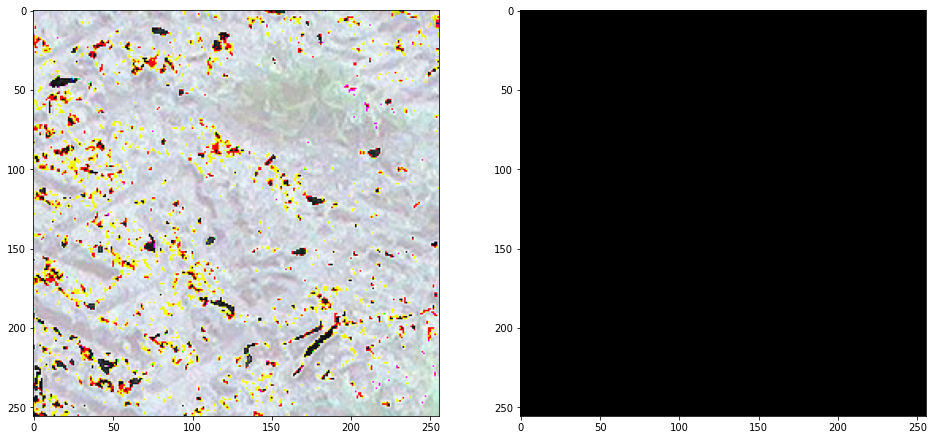

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder Unet shape

In [21]:
base_model = tf.keras.applications.ResNet50(input_shape=[img_w, img_h, 3], include_top=False)

for layer in base_model.layers[:-7]:
  layer.trainable = False

# Use the activations of these layers
layer_names = [
  'conv1_bn',
  'conv2_block1_2_bn',
  'conv5_block3_out'
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

94773248/94765736 [==============================] - 2s 0us/step


In [22]:
base_model.summary(line_length=110)

Model: "resnet50"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                [(None, 256, 256, 3)]   0                                                 
______________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)           (None, 262, 262, 3)     0            input_1[0][0]                        
______________________________________________________________________________________________________________
conv1_conv (Conv2D)                 (None, 128, 128, 64)    9472         conv1_pad[0][0]                      
______________________________________________________________________________________________________________
conv1_bn (BatchNormalization)       (None, 128, 128, 64)    256          conv1_conv[0][0]     

In [23]:
def create_model():
  n_classes = 3
  start_f = 512
  skips = []

  # Encoder
  # -------
  inputs = tf.keras.layers.Input(shape=[img_w, img_h, 3])
  skips = down_stack(inputs)
  x = skips[-1]
  skips = skips[:-1]

  x = tf.keras.layers.Conv2D(filters=start_f,
                                kernel_size=(3, 3),
                                strides=(1, 1),
                                padding='same',
                                activation='relu')(x)
  # Decoder
  # -------
  for i in range(5):
    start_f = start_f // 2
    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
    if i==2:
      x = tf.keras.layers.Concatenate()([skips[1],x])
    if i==3:
      x = tf.keras.layers.Concatenate()([skips[0],x])
    x = tf.keras.layers.Conv2D(filters=start_f,
                                kernel_size=(3, 3),
                                strides=(1, 1),
                                padding='same',
                                activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

  # Prediction Layer
  # ----------------
  x = tf.keras.layers.Conv2D(filters=n_classes,
                            kernel_size=(1, 1),
                            strides=(1, 1),
                            padding='same',
                            activation='softmax')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = create_model()

In [24]:
model.summary(line_length=110)

Model: "model_1"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_2 (InputLayer)                [(None, 256, 256, 3)]   0                                                 
______________________________________________________________________________________________________________
model (Functional)                  [(None, 128, 128, 64),  23587712     input_2[0][0]                        
______________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, 8, 8, 512)       9437696      model[0][2]                          
______________________________________________________________________________________________________________
up_sampling2d (UpSampling2D)        (None, 16, 16, 512)     0            conv2d[0][0]          

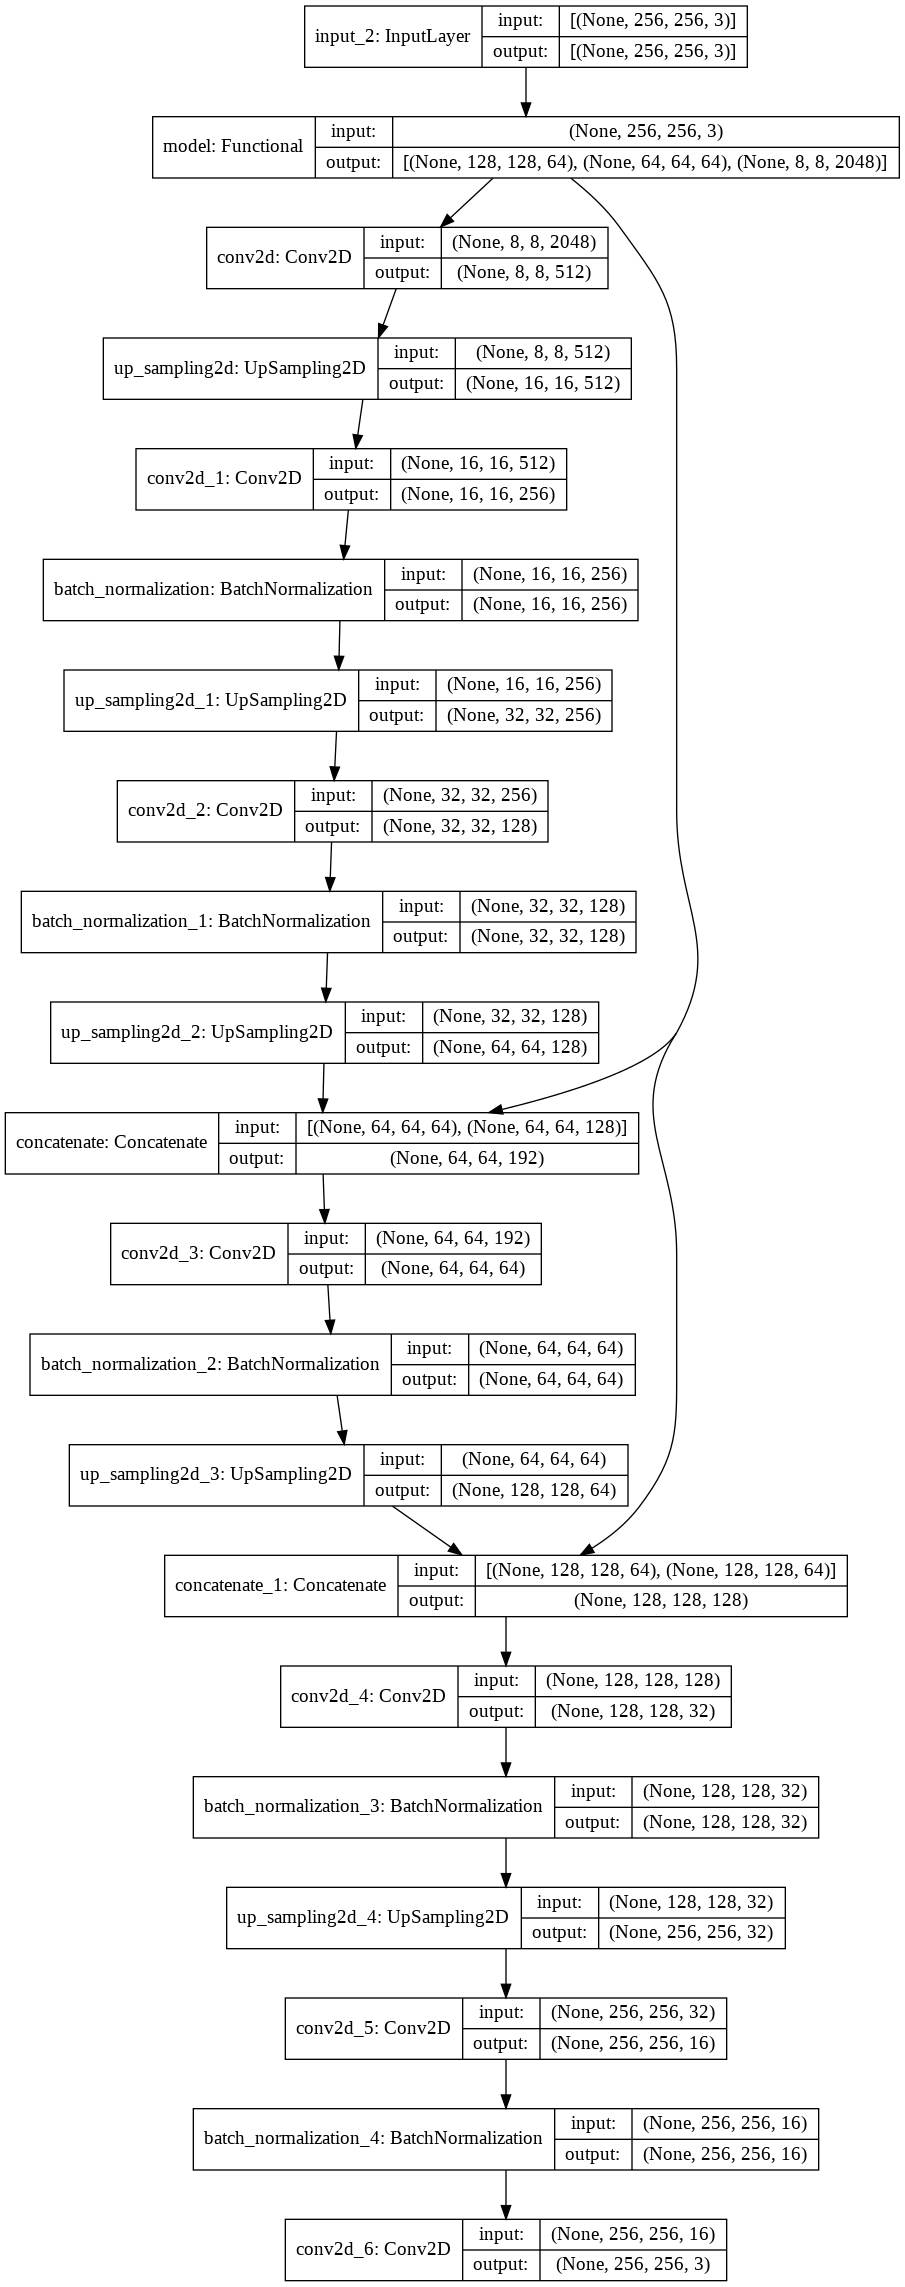

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Prepare the model for training

In [26]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [27]:
import os
from datetime import datetime

exps_dir = os.path.join(cwd, 'Checkpoints')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

name, train_dataset, train_gen, valid_dataset, valid_gen = alldata

print("Training {}".format(name))
exp_dir = os.path.join(exps_dir, name)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
filep = os.path.join(exp_dir, 'cp_{epoch:02d}.ckpt')
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filep,
                                                   save_weights_only=True,)  # False to save the model directly
callbacks.append(ckpt_callback)

model.fit(x=train_dataset,
          epochs=1,
          steps_per_epoch=len(train_gen)//BATCH_SIZE,
          validation_data=valid_dataset,
          validation_steps=len(valid_gen)//BATCH_SIZE,
          callbacks=callbacks)

Training Whole_dataset
Epoch 1/2
807/807 [==============================] - 2588s 3s/step - loss: 0.3014 - accuracy: 0.9517 - meanIoU: 0.5648
Epoch 2/2
 25/807 [..............................] - ETA: 41:30 - loss: 0.0624 - accuracy: 0.9791 - meanIoU: 0.6736

KeyboardInterrupt: ignored

In [28]:
for dataset in datasets:
  model.load_weights(os.path.join('Checkpoints', 'Whole_dataset', 'cp_01.ckpt'))
  name, train_dataset, train_gen, valid_dataset, valid_gen = dataset

  print("Training {}".format(name))
  exp_dir = os.path.join(exps_dir, name)
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  filep = os.path.join(exp_dir, 'cp_{epoch:02d}.ckpt')
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filep, 
                                                     save_weights_only=True,)  # False to save the model directly
  callbacks.append(ckpt_callback)

  model.fit(x=train_dataset,
            epochs=3,
            steps_per_epoch=len(train_gen)//BATCH_SIZE,
            validation_data=valid_dataset,
            validation_steps=len(valid_gen)//BATCH_SIZE,
            callbacks=callbacks)

Training BipbipHaricot
Epoch 1/3
39/39 [==============================] - 121s 3s/step - loss: 0.0779 - accuracy: 0.9740 - meanIoU: 0.7199
Epoch 2/3
39/39 [==============================] - 102s 3s/step - loss: 0.0662 - accuracy: 0.9772 - meanIoU: 0.7601
Epoch 3/3
39/39 [==============================] - 96s 2s/step - loss: 0.0592 - accuracy: 0.9790 - meanIoU: 0.7863


Training BipbipMais
Epoch 1/3
39/39 [==============================] - 122s 3s/step - loss: 0.0735 - accuracy: 0.9750 - meanIoU: 0.7893
Epoch 2/3
39/39 [==============================] - 96s 3s/step - loss: 0.0639 - accuracy: 0.9773 - meanIoU: 0.8139
Epoch 3/3
39/39 [==============================] - 96s 2s/step - loss: 0.0588 - accuracy: 0.9785 - meanIoU: 0.8271


Training PeadHaricot
Epoch 1/3
106/106 [==============================] - 337s 3s/step - loss: 0.0793 - accuracy: 0.9731 - meanIoU: 0.6127
Epoch 2/3
106/106 [==============================] - 288s 3s/step - loss: 0.0692 - accuracy: 0.9747 - meanIoU: 0.6396
Epoch 3/3
106/106 [==============================] - 265s 3s/step - loss: 0.0633 - accuracy: 0.9760 - meanIoU: 0.6617


Training PeadMais
Epoch 1/3
106/106 [==============================] - 338s 3s/step - loss: 0.0961 - accuracy: 0.9718 - meanIoU: 0.4377
Epoch 2/3
106/106 [==============================] - 307s 3s/step - loss: 0.0806 - accuracy: 0.9728 - meanIoU: 0.4596
Epoch 3/3
106/106 [==============================] - 266s 2s/step - loss: 0.0676 - accuracy: 0.9744 - meanIoU: 0.4918


Training RoseauHaricot
Epoch 1/3
16/16 [==============================] - 51s 3s/step - loss: 0.1831 - accuracy: 0.9465 - meanIoU: 0.5219
Epoch 2/3
16/16 [==============================] - 45s 3s/step - loss: 0.1563 - accuracy: 0.9538 - meanIoU: 0.5758
Epoch 3/3
16/16 [==============================] - 39s 2s/step - loss: 0.1304 - accuracy: 0.9588 - meanIoU: 0.6298


Training RoseauMais
Epoch 1/3
16/16 [==============================] - 52s 3s/step - loss: 0.1576 - accuracy: 0.9710 - meanIoU: 0.4935
Epoch 2/3
16/16 [==============================] - 39s 3s/step - loss: 0.0804 - accuracy: 0.9796 - meanIoU: 0.5744
Epoch 3/3
16/16 [==============================] - 39s 2s/step - loss: 0.0635 - accuracy: 0.9820 - meanIoU: 0.6327


Training WeedelecHaricot
Epoch 1/3
241/241 [==============================] - 769s 3s/step - loss: 0.0664 - accuracy: 0.9767 - meanIoU: 0.7477
Epoch 2/3
241/241 [==============================] - 768s 3s/step - loss: 0.0559 - accuracy: 0.9794 - meanIoU: 0.7839
Epoch 3/3
241/241 [==============================] - 765s 3s/step - loss: 0.0487 - accuracy: 0.9814 - meanIoU: 0.8095


Training WeedelecMais
Epoch 1/3
241/241 [==============================] - 769s 3s/step - loss: 0.0381 - accuracy: 0.9885 - meanIoU: 0.7576
Epoch 2/3
241/241 [==============================] - 763s 3s/step - loss: 0.0320 - accuracy: 0.9893 - meanIoU: 0.7782
Epoch 3/3
241/241 [==============================] - 765s 3s/step - loss: 0.0285 - accuracy: 0.9899 - meanIoU: 0.7931


## Test model

## Compute prediction

In [29]:
# Test set
# --------
 
import time
from matplotlib import cm
import matplotlib.pyplot as plt
 
from PIL import Image
 
%matplotlib inline
 
# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
 
path = os.path.join(cwd, 'Development_Dataset')
dataset_dirs = [os.path.join(path, 'Test_Dev', 'Bipbip', 'Mais')]
 
imgs_path = []
for dataset_dir in dataset_dirs:
    img_path = os.path.join(dataset_dir, 'Images')
    fnames = os.listdir(img_path)
    paths = [os.path.join(img_path, fname) for fname in fnames]
    imgs_path.extend(paths)
    
iterator = iter(imgs_path)

In [30]:
model.load_weights(os.path.join('Checkpoints', 'PeadMais', 'cp_03.ckpt'))

ValueError: ignored

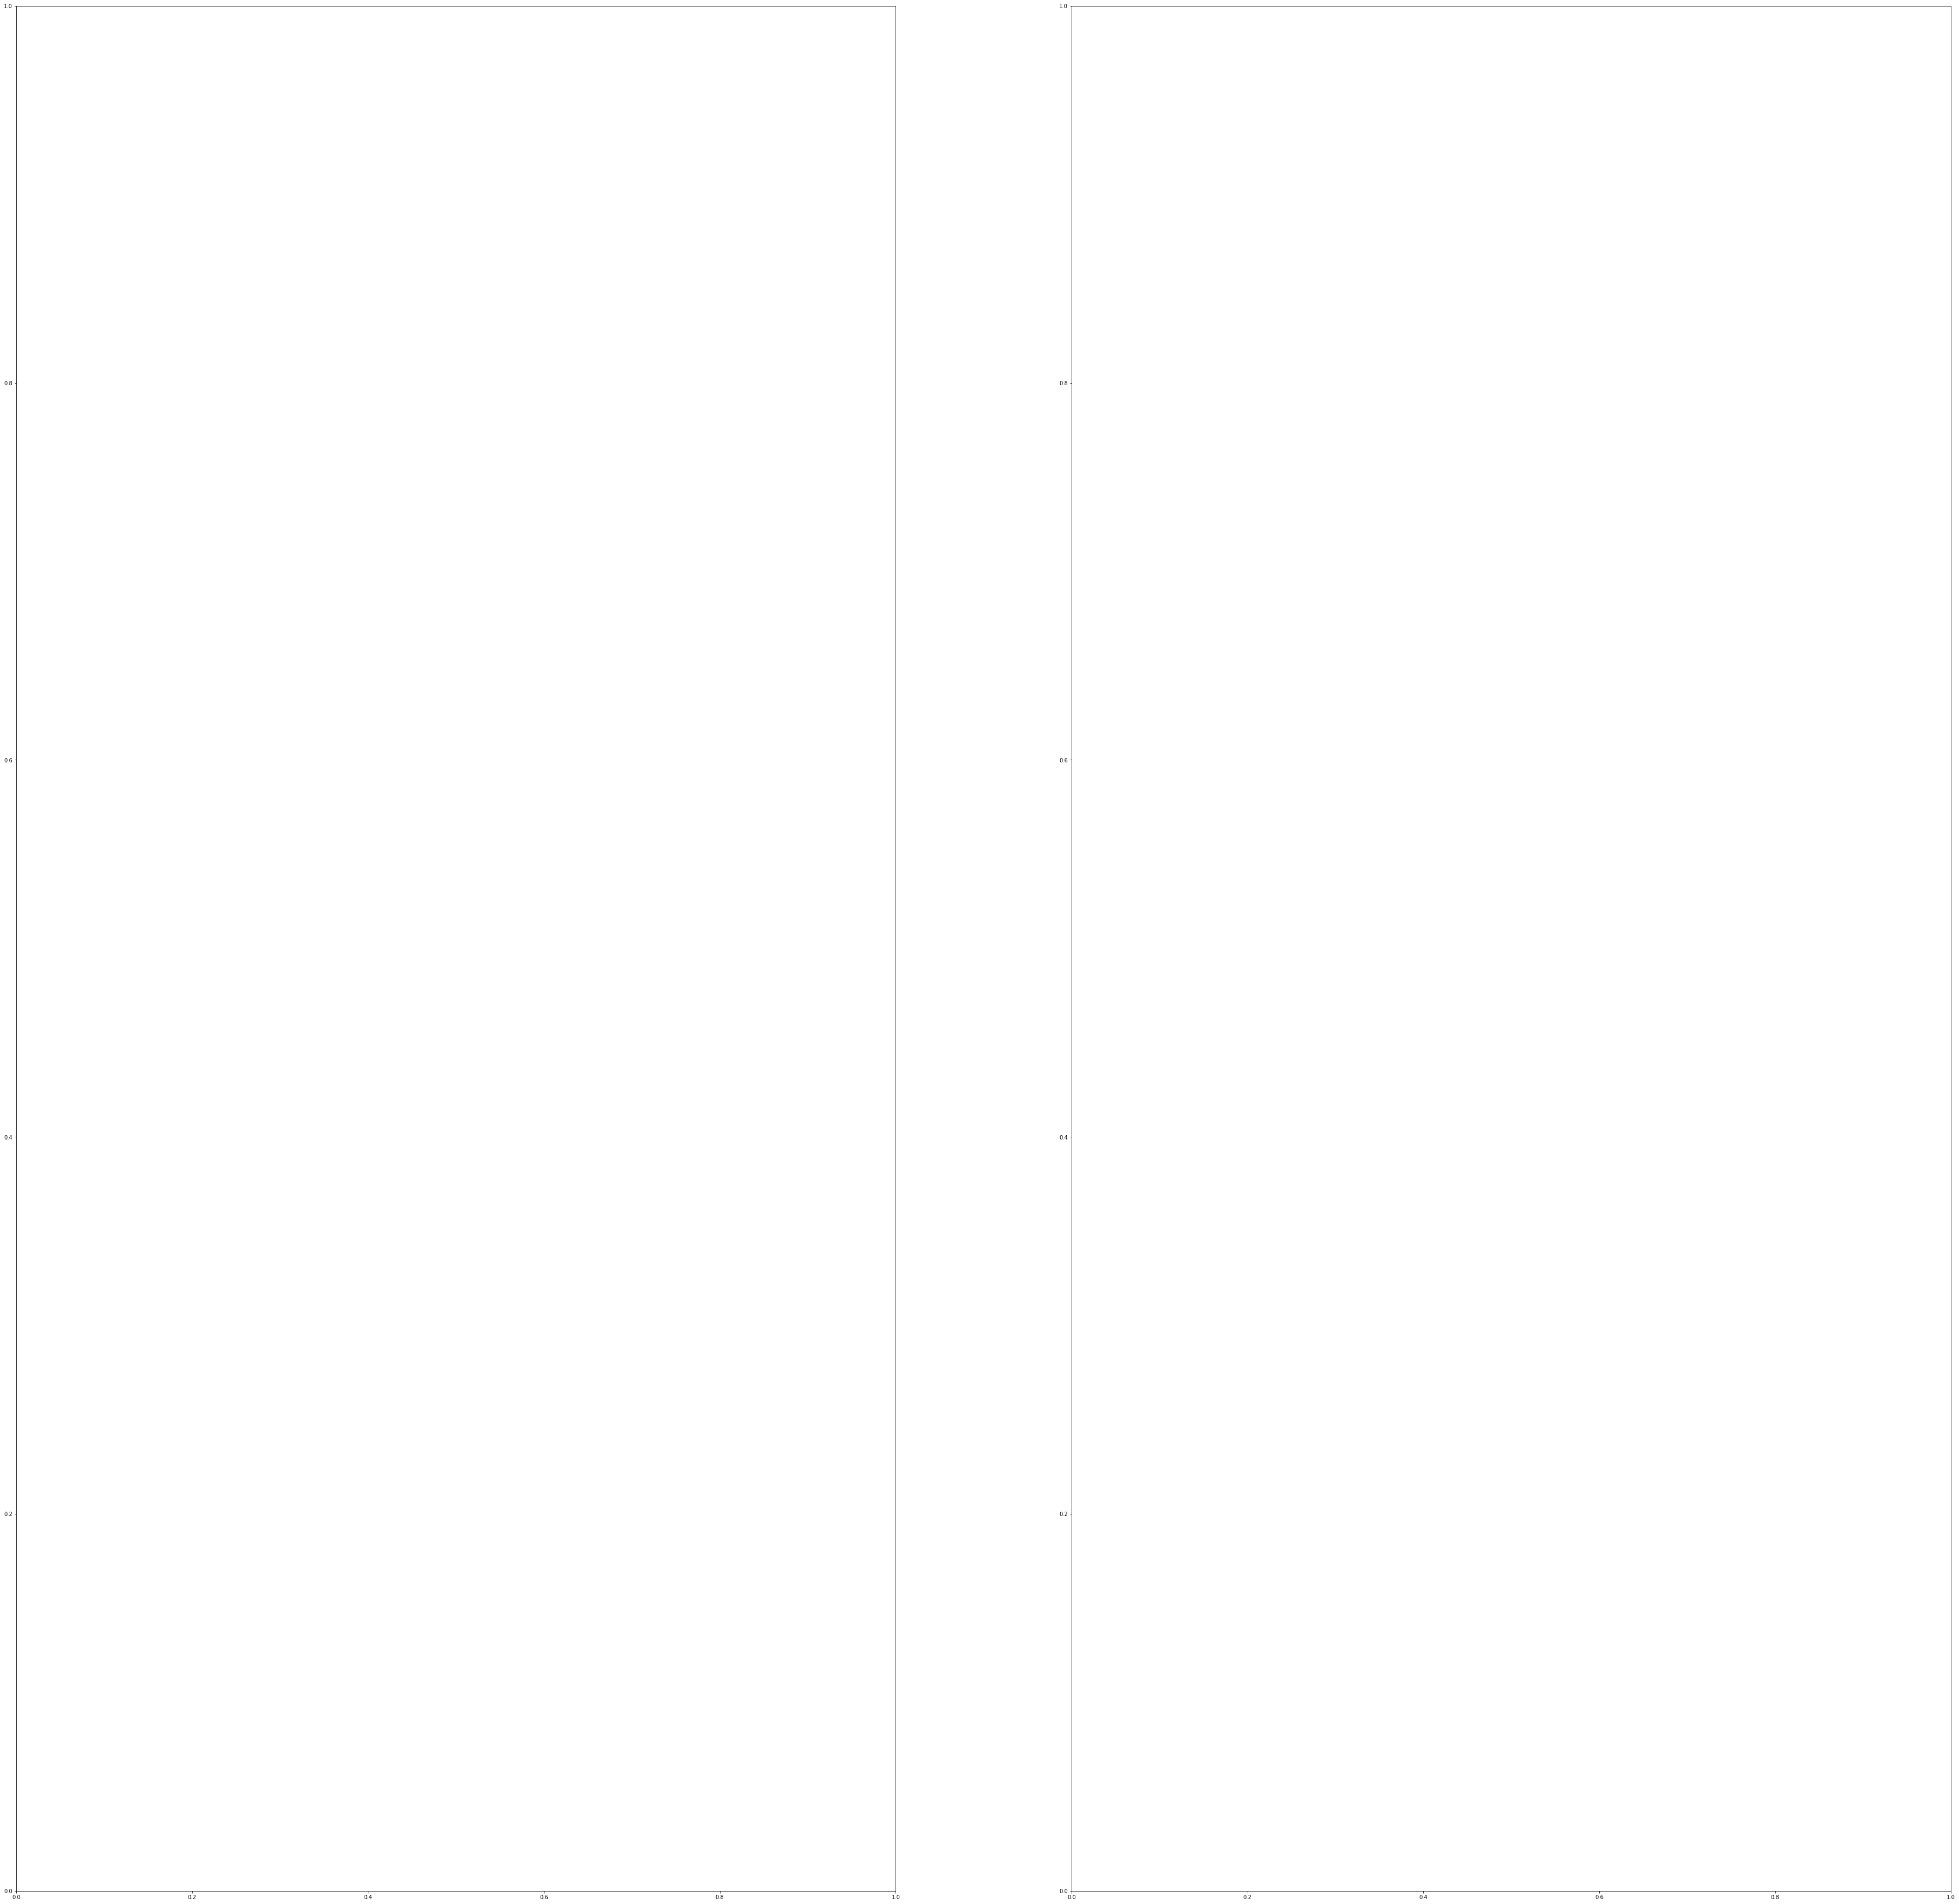

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(64, 64))
fig.show()
img_path = next(iterator)
 
image = np.array(Image.open(img_path))
x = preprocess_input(image)
 
out_sigmoid = model.predict(x=tf.expand_dims(x, 0))
 
# Get predicted class as the index corresponding to the maximum value in the vector probability
predicted_class = tf.argmax(out_sigmoid, -1)
 
out_sigmoid.shape
 
predicted_class = predicted_class[0, ...]
 
# Assign colors (just for visualization)
prediction_img = np.zeros([predicted_class.shape[0], predicted_class.shape[1], 3])
 
prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
prediction_img[np.where(predicted_class == 2)] = [216, 67, 82]
 
ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))
 
fig.canvas.draw()
time.sleep(1)

In [32]:
def unpatching(img_arr, patches, window):
  height, width, _ = img_arr.shape
 
  cols = math.ceil(width/window)
  rows = math.ceil(height/window)
  w_off = width % window
  h_off = height % window
 
  img_rows = []
  for row in range(rows):
    if w_off != 0:
      patches[row*cols+cols-1] = patches[row*cols+cols-1][:,-w_off:,...]
    img_rows.append(np.concatenate(patches[row*cols:row*cols+cols], axis=1))
 
  if h_off != 0:
    img_rows[-1] = img_rows[-1][-h_off:,...]
  img_arr = np.concatenate(img_rows, axis=0)
  
  return img_arr

In [33]:
import os
import json
import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet import preprocess_input 
 
# Submission
# ----------
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
submission_dict = {}
path = os.path.join(cwd, 'Development_Dataset')
for crop in crops:
  for team in teams:
    # Load model
    model.load_weights(os.path.join('Checkpoints', team+crop, 'cp_03.ckpt'))
    dataset_dir = os.path.join(path, 'Test_Dev', team, crop)
 
    img_path = os.path.join(dataset_dir, 'Images')
    fnames = os.listdir(img_path)
 
    # Removing extensions
    fnames = [os.path.splitext(fname)[0] for fname in fnames]
    # Read Image
    for img_name in fnames: 
      print("Encoding... {} ".format(img_name), end='-')
      if 'Roseau' in img_name:
        img_path = os.path.join(dataset_dir, 'Images', img_name + '.png')
      else:
        img_path = os.path.join(dataset_dir, 'Images', img_name + '.jpg')
 
      img = Image.open(img_path)
      img_arr = np.array(img)
 
      # Preprocess input
      img_pre = preprocess_input(img_arr)
 
      patches = patching(img_pre, window)
 
      msk_patches = []
      for patch in patches:
        out_sigmoid = model.predict(x=tf.expand_dims(patch, 0))
        msk_arr = tf.argmax(out_sigmoid, -1)
        msk_arr = msk_arr.numpy()
        msk_arr = np.squeeze(msk_arr, axis=0)
        msk_patches.append(msk_arr)
 
      msk_out = unpatching(img_arr, msk_patches, window)
      print(np.unique(msk_out))
      print("\tInput - {}, Output - {}".format(img_arr.shape, msk_out.shape))
 
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = msk_out.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = crop
      submission_dict[img_name]['segmentation'] = {}
 
      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(msk_out == 1)
      # weed
      rle_encoded_weed = rle_encode(msk_out == 2)
 
      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

Encoding... Bipbip_haricot_im_04701 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_07291 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_07241 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_07641 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_08301 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_04191 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_02971 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_03171 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_04251 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_03911 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_haricot_im_03391 -[0 1 2]
	Input - (1536, 2048, 3),

Encoding... Pead_haricot_00104_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00044_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00083_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00252_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00611_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00258_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00297_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00211_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00013_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00409_i750 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_haricot_00336_i750 -[0 1 2]
	Input - (2464, 3280, 3),

Encoding... Roseau_haricot_0030_false -[0 1 2]
	Input - (819, 1228, 3), Output - (819, 1228)
Encoding... Roseau_haricot_0196_false -[0 1 2]
	Input - (819, 1229, 3), Output - (819, 1229)
Encoding... Roseau_haricot_0368_false -[0 1]
	Input - (819, 1226, 3), Output - (819, 1226)
Encoding... Roseau_haricot_0216_false -[0 1 2]
	Input - (819, 1228, 3), Output - (819, 1228)
Encoding... Roseau_haricot_0146_false -[0 1 2]
	Input - (819, 1228, 3), Output - (819, 1228)
Encoding... Roseau_haricot_0002_false -[0 1 2]
	Input - (819, 1226, 3), Output - (819, 1226)
Encoding... Roseau_haricot_0006_false -[0 1 2]
	Input - (819, 1226, 3), Output - (819, 1226)
Encoding... Roseau_haricot_0328_false -[0]
	Input - (819, 1226, 3), Output - (819, 1226)
Encoding... Roseau_haricot_0376_false -[0 1 2]
	Input - (819, 1228, 3), Output - (819, 1228)
Encoding... Roseau_haricot_0066_false -[0 1]
	Input - (819, 1227, 3), Output - (819, 1227)
Encoding... Roseau_haricot_0086_false -[0 1]
	Input - (820, 1227, 3), Output -

Encoding... Weedelec_haricot_2019-09-25T115557-283 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T114716-82 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T115526-271 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T114542-46 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T120154-421 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T114908-125 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T115349-234 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T115859-353 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_2019-09-25T114816-105 -[0 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_haricot_201

Encoding... Bipbip_mais_im_03071 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_09391 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_04191 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_03021 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_02601 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_08191 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_08961 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_02561 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_03461 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_10611 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding... Bipbip_mais_im_08891 -[0 1 2]
	Input - (1536, 2048, 3), Output - (1536, 2048)
Encoding..

Encoding... Pead_mais_00253_i900 -[0 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00261_i900 -[0 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00237_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00391_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00560_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00089_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00760_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00719_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00042_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00703_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pead_mais_00066_i900 -[0 1 2]
	Input - (2464, 3280, 3), Output - (2464, 3280)
Encoding... Pe

Encoding... Roseau_mais_0130_false -[0 1 2]
	Input - (820, 1228, 3), Output - (820, 1228)
Encoding... Roseau_mais_0300_false -[0 1 2]
	Input - (820, 1227, 3), Output - (820, 1227)
Encoding... Roseau_mais_0076_false -[0 1 2]
	Input - (820, 1227, 3), Output - (820, 1227)
Encoding... Roseau_mais_0372_false -[0 1 2]
	Input - (819, 1227, 3), Output - (819, 1227)
Encoding... Roseau_mais_0364_false -[0 1 2]
	Input - (820, 1225, 3), Output - (820, 1225)
Encoding... Roseau_mais_0340_false -[0 1 2]
	Input - (820, 1226, 3), Output - (820, 1226)
Encoding... Roseau_mais_0250_false -[0 1 2]
	Input - (820, 1226, 3), Output - (820, 1226)
Encoding... Roseau_mais_0282_false -[0 1 2]
	Input - (821, 1227, 3), Output - (821, 1227)
Encoding... Roseau_mais_0020_false -[0 1 2]
	Input - (822, 1228, 3), Output - (822, 1228)
Encoding... Roseau_mais_0152_false -[0 1 2]
	Input - (819, 1227, 3), Output - (819, 1227)
Encoding... Roseau_mais_0162_false -[0 1 2]
	Input - (821, 1226, 3), Output - (821, 1226)
Encoding..

Encoding... Weedelec_mais_2019-09-25T121833-303 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T122104-362 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T120844-74 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T122026-347 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T120552-8 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T120616-17 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T121032-116 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T121536-234 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T122303-409 -[0 1 2]
	Input - (3456, 5184, 3), Output - (3456, 5184)
Encoding... Weedelec_mais_2019-09-25T120925-90 -[0 1 2]
	In

In [34]:
len(submission_dict)

160

In [35]:
# Finally, save the results into the submission.json file
with open('submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [36]:
!cp submission.json /content/drive/MyDrive/